## Intitialization

In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
from pprint import pprint
import collections

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import axes3d
from matplotlib.transforms import Bbox
from matplotlib import cm 
from matplotlib.ticker import MaxNLocator
from sklearn.base import clone



import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict,cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,roc_curve,\
classification_report,confusion_matrix, ConfusionMatrixDisplay,mean_squared_error,r2_score,roc_auc_score,auc
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize


from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import seaborn as sns
from scipy import stats

from IPython.display import Image
pd.set_option('max_colwidth', 800)


In [2]:
usr='4ua'
routes_class={'Route1':1,'Route2':2}


# plots saving/showing configurations
save_file_flag=True
show_IV_plot=True

data_path=f"C:\\Users\\{usr}\\OneDrive - Oak Ridge National Laboratory\\4UA-ORNL-Projects\\HECATE\\UQ-dataset"
result_path=f"C:\\Users\\{usr}\\OneDrive - Oak Ridge National Laboratory\\4UA-ORNL-Projects\\HECATE\\UQ-dataset\\results"



routes_qos=np.loadtxt(f"{data_path}\\routes_bw.txt", comments='#',dtype=float)
routes_label=np.loadtxt(f"{data_path}\\bw_routes_label.txt",dtype=int, comments='#')

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(routes_qos, 
                                                    routes_label, 
                                                    test_size = 0.2,
                                                    random_state=1234,
                                                    shuffle = True, stratify = None)


In [3]:
# function to return key for any value

def get_key(val,mydict):

	for key, value in mydict.items():
		if val == value:
			return key
        
def count_label(labels,labels_dic):
    label_buf=collections.Counter(labels)
    counted_labels_dic={get_key(key1,labels_dic):value1 for key1,value1 in label_buf.items()}
    return counted_labels_dic

In [52]:
def lines_plot(df_i,save_path,title_str='',y_label='',x_label='',save_file=''):
    
    fig=plt.figure()
    for key in df_i.keys():
        plt.plot(np.arange(len(df_i[key])),df_i[key],marker='x',label=key)
    plt.xticks(np.arange(len(df_i[key])),list(map(str,np.arange(1,len(df_i[key])+1,1))))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_str)
    #plt.legend(loc="best",bbox_to_anchor=(0.6, 0.4), ncol=2)
    plt.legend(loc="best")
    plt.grid()
    if save_file:
         plt.savefig(f"{os.path.join(save_path, save_file)}", dpi=300, format='pdf', bbox_inches='tight')
    plt.show()


def create_boxplot(valu_vec,save_path,date_set,title_str='',y_label='',x_label='',save_file=''):

    meanpointprops = dict(marker='+', markeredgecolor='darkgoldenrod',markerfacecolor='red')
    medianprops = dict(linestyle='-', linewidth=1, color='red')

    pltbx=plt.boxplot(valu_vec, showfliers=False,labels=date_set,meanprops=meanpointprops,medianprops=medianprops,
            showmeans=True,patch_artist=True)
    means_vals = [item.get_ydata()[0] for item in pltbx['means']]
    plt.setp(pltbx['boxes'], color='blue',facecolor='white')
    plt.title("%s"%title_str)
    #plt.ylim(0,10)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #plt.xticks(rotation = 45)
    legend_elements = [Line2D([0], [0], color='red', lw=1, label='Median'),
                    Line2D([0], [0], color='darkgoldenrod',marker='+',label='Mean'),
                  Line2D([0], [0], color='blue', lw=1, label='25%-75%'),
                   Line2D([0], [0], color='black', lw=1, label='9%-91%')]
    plt.legend(handles=legend_elements,loc='best',  fancybox=True, framealpha=1)
    plt.grid()
    if save_file:
         plt.savefig(f"{os.path.join(save_path, save_file)}", dpi=300, format='pdf', bbox_inches='tight')
    plt.show()
    return means_vals

#####################################################################################################################

def call_compute_color_position(ax,confusion_mat):
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='large')
    ax.tick_params(top=False, bottom=True,labeltop=False, labelbottom=True)
    #ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    return ax   

def plot_matrix(conf_mat,class_labels,classifier,title_str='',save_path='',save_file=''):
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    cax=axes.matshow(conf_mat, cmap=plt.cm.YlGnBu, alpha=0.8)
    fig.colorbar(cax)
    axes=call_compute_color_position(axes,conf_mat)
    axes.set_xlabel('Predictions')
    axes.set_ylabel('Actuals')
    axes.set_title(f'{title_str}',fontsize=10)
    axes.set_xticklabels([''] + class_labels)
    axes.set_yticklabels([''] + class_labels)
    if save_file:
        file_to_save=f"{save_file}_{classifier}.pdf"
        plt.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=300, bbox_inches='tight')
    plt.show()
    

In [5]:
def plot_roc_curve(y_test_binarized,class_labels,classifier,y_pred_proba,title_str='',save_path='',save_file=''):

    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = dict()

    n_class = len(class_labels)

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[i], y_pred_proba[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i]) 
        # plotting    
        plt.plot(fpr[i], tpr[i], linestyle='--', 
                 label='%s vs Others (AUC=%0.2f)'%(class_labels[i],roc_auc[i]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_class

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

     

    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle="-.",linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle="-.",linewidth=2)

    
    plt.plot([0,1],[0,1], color='black',linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    #plt.title(f"{title_str}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='lower right')
    if save_file:
        file_to_save=f"{save_file}_{classifier}.pdf"
        plt.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(0.98 + pad, 1.12 + pad)



def plot_Prob_Dist_OvR(class_labels,classifier,y_pred_proba,y_target,title_str='',save_path='',save_file=''):
    fig=plt.figure(figsize = (15, 4))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    prob_class_dic={}
    i=0
    for key,value in class_labels.items():
        class_binary = [1 if y == value else 0 for y in y_target]

        # Prepares an auxiliar dataframe to help with the plots
        prob_class_dic['class'] = class_binary
        prob_class_dic['prob'] = y_pred_proba[:, i]
        df_aux=pd.DataFrame(prob_class_dic)
        df_aux = df_aux.reset_index(drop = True)
        

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(1, 4, i+1)
        #fig=sns.histplot(x='prob',data = df_aux, color = 'b', hue = 'class',ax = ax, bins = bins).get_figure()
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        sns.histplot(x='prob',data = df_aux, color = 'b', hue = 'class',ax = ax, bins = bins)
        #ax.set_title(value)
        ax.legend([f"Class: {key}", "Rest"])
        ax.set_xlabel(f"P(x = {key})")
        i=i+1
        if save_file:
            extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
            file_to_save=f"{save_file}_{classifier}_{key}.pdf"
            fig.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=350,bbox_inches=extent)
            
    plt.tight_layout()
    plt.show()

In [7]:
def modelCrossVal(X_train, y_train,folds=5,binary_classification=True):
    
    log_reg = LogisticRegression()
    knn = KNeighborsClassifier()
    svmsvc = svm.SVC(probability=True)
    dt = tree.DecisionTreeClassifier()
    et = ExtraTreesClassifier()
    rf = RandomForestClassifier()
    gnb = GaussianNB()
    
    cv_df= pd.DataFrame(columns=['Model','Acc.avg','Acc.std','roc_auc_score'])
    
    pipelines=[]
    y_pred_dic= {}
    y_predproba_dic= {}
    confusion_matrix_dic={}
    clfs = [
            ('LogisticRegression', log_reg), 
            ('KNeighbors', knn), 
            ('svc', svmsvc), 
            ('DecisionTree', dt), 
            ('ExtraTrees', et), 
            ('RandomForest', rf),
            ('GaussianNB', gnb)
            ]
    for clf_name, clf in clfs:

        pipeline = Pipeline(steps=[
                                  ('classifier', clf)
                                  ]
                           ) 
        
        scores=cross_val_score(pipeline, X_train, y_train, cv=folds,scoring='accuracy')
        
        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=folds, method='predict') 
        y_predproba = cross_val_predict(pipeline, X_train, y_train, cv=folds, method='predict_proba')
        cm=confusion_matrix(y_train, y_pred)
        #print("roc_auc_score clf.predict_proba ",roc_auc_score(y_train, y_predproba, multi_class='ovr'))
        if binary_classification:
            roc_auc_score_value=roc_auc_score(y_train, y_predproba[:, 1],average="macro")
        else:
            roc_auc_score_value=roc_auc_score(y_train, y_predproba, multi_class='ovr',average="macro")
            
        cv_df = cv_df.append({
                              'Model' : clf_name,
                              'Acc.avg':"%0.3f" %(scores.mean()),
                              'Acc.std':"%0.3f" %(scores.std()),
                              'roc_auc_score':"%0.3f" %(roc_auc_score_value)  
                                          }, 
                                         ignore_index=True)
        
        pipelines.append(pipeline)
        confusion_matrix_dic[clf_name]=cm
        y_pred_dic[clf_name]=y_pred
        y_predproba_dic[clf_name]=y_predproba
    return cv_df,y_pred_dic,y_predproba_dic,confusion_matrix_dic,pipelines

# Data Analysis

In [8]:

d = {'class_label': pd.Series(routes_label),
	'routes_qos': pd.Series(routes_qos.tolist())}

df = pd.DataFrame(d)

#df
print(df['class_label'].value_counts())

print(routes_qos.shape)
print(routes_label.shape)

2    319
1    181
Name: class_label, dtype: int64
(500, 3)
(500,)


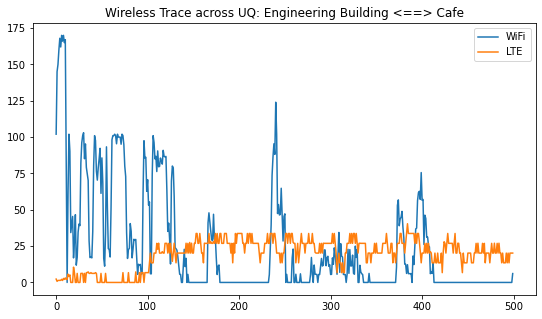

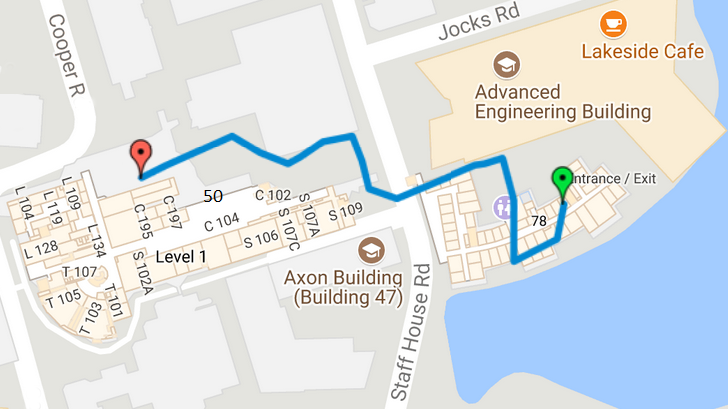

In [51]:
fig = plt.figure(figsize=(9,5))
x=np.arange(0,500)
plt.plot(x,routes_qos[:, 1],label='WiFi')
plt.plot(x,routes_qos[:, 2],label='LTE')
plt.legend()
plt.title('Wireless Trace across UQ: Engineering Building <==> Cafe')
plt.show()

Image("UQ-BW-Engineering-400ms-MAP2.png",width=550,height=300)

## Two route classes
## Cross_Val

In [38]:
# print("\n###########     Full dataset      #################\n")
cross_val_scores_df2,y_pred_dic,y_predproba_dic,confusion_matrix_dic,pipelines= modelCrossVal(routes_qos, routes_label,folds=5)
pprint(cross_val_scores_df2)




                Model Acc.avg Acc.std roc_auc_score
0  LogisticRegression   0.996   0.005         1.000
1          KNeighbors   0.932   0.056         0.952
2                 svc   0.952   0.033         0.994
3        DecisionTree   0.942   0.066         0.932
4          ExtraTrees   0.902   0.085         0.963
5        RandomForest   0.870   0.178         0.970
6          GaussianNB   0.950   0.031         0.994


### Confusion Matrix

##############    LogisticRegression    ################


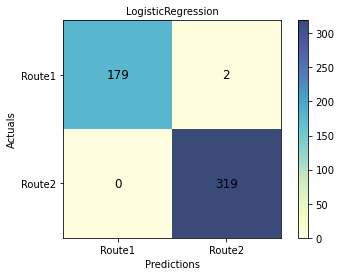

##############    KNeighbors    ################


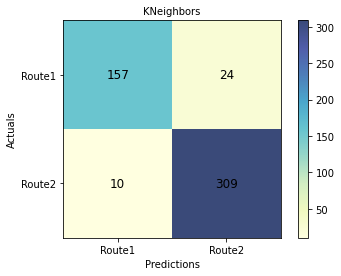

##############    svc    ################


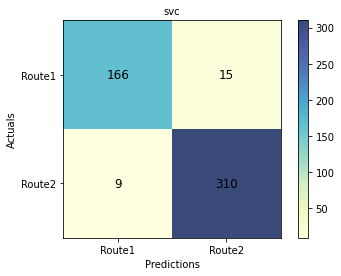

##############    DecisionTree    ################


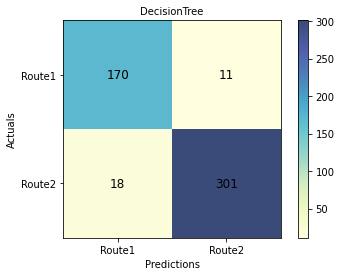

##############    ExtraTrees    ################


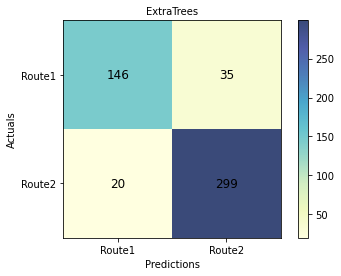

##############    RandomForest    ################


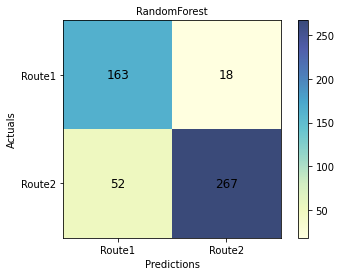

##############    GaussianNB    ################


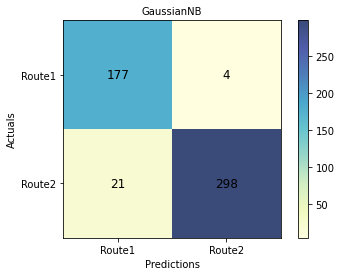

In [57]:
for key, values in confusion_matrix_dic.items():
    print(f"##############    {key}    ################")
    plot_matrix(confusion_matrix_dic[key],list(routes_class.keys()),key,title_str=key,save_path=result_path,save_file='cross_val_cm')

## Probability Distribution

##############    LogisticRegression    ################


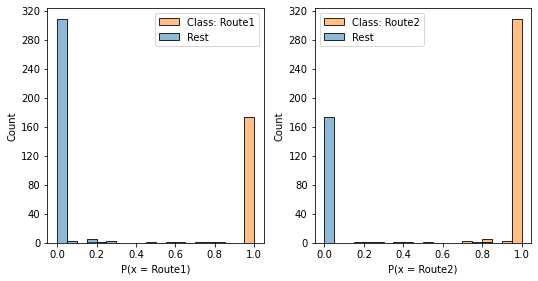

##############    KNeighbors    ################


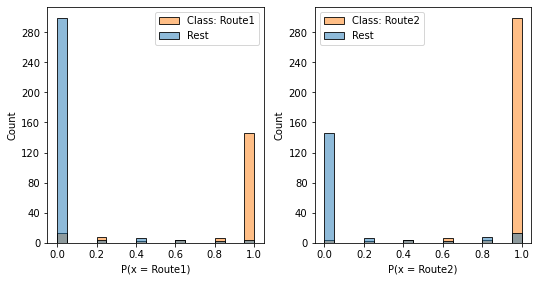

##############    svc    ################


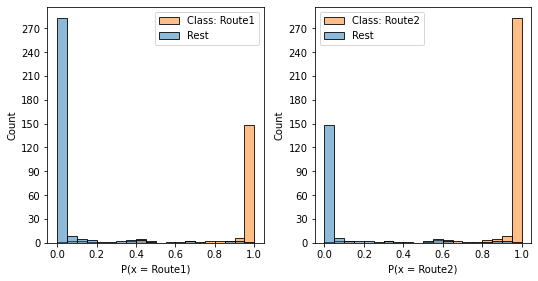

##############    DecisionTree    ################


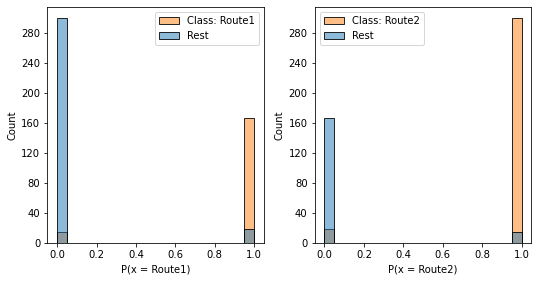

##############    ExtraTrees    ################


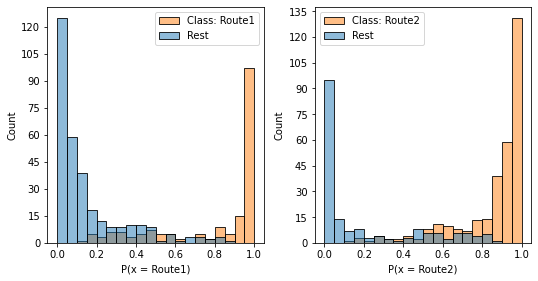

##############    RandomForest    ################


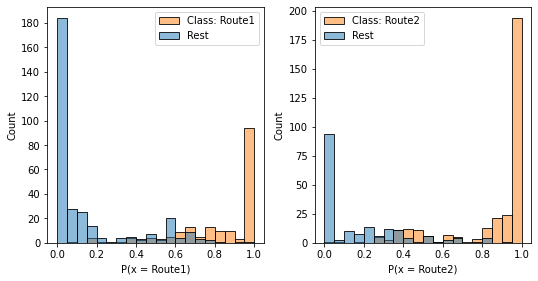

##############    GaussianNB    ################


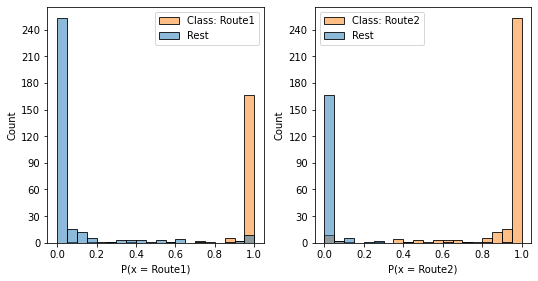

In [40]:
for key, values in y_predproba_dic.items():
    print(f"##############    {key}    ################")
    plot_Prob_Dist_OvR(routes_class,key,values,routes_label,title_str='',save_path=result_path,save_file='cross_val_prob-dist')

### Roc Curve

In [75]:
# y_test_binarized=label_binarize(routes_label,classes=np.unique(routes_label))
# for key, values in y_predproba_dic.items():
#     print(f"##############    {key}    ################")
#     plot_roc_curve(y_test_binarized,list(routes_class.keys()),key,values,title_str=key,save_path=result_path,save_file='cross_val_roc-curve')

for key, values in y_predproba_dic.items():
    print(f"##############    {key}    ################")
    plot_roc_curve(routes_label,list(routes_class.keys()),key,values,title_str=key,save_path=result_path,save_file='cross_val_roc-curve')

##############    LogisticRegression    ################


TypeError: Singleton array 1 cannot be considered a valid collection.